In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### 데이터 세팅

In [50]:
train_df = pd.read_parquet("/Data/nh25/credit/dataset/train_df.parquet")
test_df = pd.read_parquet("/Data/nh25/credit/dataset/test_df.parquet")

In [3]:
train_df

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0.999998,1.042805,0.999700,0.999998,0.999998,0.261886,0.270752,0.000000,1.044401,1.280543
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,1.092698,0.905663,0.999998,0.999998,0.999998,-0.563388,-0.670348,0.000000,0.000000,0.000000
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,1.006124,1.993590,0.852567,0.999998,0.999998,-0.046516,0.058114,-0.014191,0.524159,1.208420
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0.999998,1.050646,0.999877,0.999998,0.999998,0.023821,0.258943,0.000000,0.880925,1.657124
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,2,70대이상,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
2399996,201812,TRAIN_399996,2,50대,D,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.921733,-0.203251,-0.159143,0.000000,1.377071,2.533815
2399997,201812,TRAIN_399997,1,30대,C,1,1,0,1,1,...,0.999998,0.345027,0.999998,0.999998,0.999998,0.027319,0.126581,0.000000,0.000000,0.000000
2399998,201812,TRAIN_399998,1,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN


In [4]:
train_df.isnull().sum().sort_values(ascending=False).head(20)

연체일자_B0M          2394336
_3순위여유업종          2377725
_3순위납부업종          2310187
_2순위여유업종          2302286
_3순위교통업종          2045455
_2순위납부업종          2033640
최종카드론_대출일자        1988330
_1순위여유업종          1987260
최종카드론_신청경로코드      1958226
최종카드론_금융상환방식코드    1958126
RV신청일자            1951236
_2순위교통업종          1656423
OS구분코드            1633566
_3순위쇼핑업종          1312267
_1순위납부업종          1216263
_1순위교통업종          1164494
_2순위쇼핑업종          1135042
_3순위업종            1107898
_2순위신용체크구분         958115
_1순위쇼핑업종           922663
dtype: int64

In [3]:
# 결측치가 80% 이상인 컬럼은 삭제
threshold = 0.8
train_df = train_df.loc[:, train_df.isnull().mean() < threshold]

In [6]:
train_df

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0.999998,1.042805,0.999700,0.999998,0.999998,0.261886,0.270752,0.000000,1.044401,1.280543
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,1.092698,0.905663,0.999998,0.999998,0.999998,-0.563388,-0.670348,0.000000,0.000000,0.000000
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,1.006124,1.993590,0.852567,0.999998,0.999998,-0.046516,0.058114,-0.014191,0.524159,1.208420
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0.999998,1.050646,0.999877,0.999998,0.999998,0.023821,0.258943,0.000000,0.880925,1.657124
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,2,70대이상,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
2399996,201812,TRAIN_399996,2,50대,D,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.921733,-0.203251,-0.159143,0.000000,1.377071,2.533815
2399997,201812,TRAIN_399997,1,30대,C,1,1,0,1,1,...,0.999998,0.345027,0.999998,0.999998,0.999998,0.027319,0.126581,0.000000,0.000000,0.000000
2399998,201812,TRAIN_399998,1,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN


### Feature selection

클래스 비율 불균형에 따른 resampling (& 데이터 개수 줄이기)

In [13]:
train_df['Segment'].value_counts(normalize=True)

Segment
E    0.800855
D    0.145517
C    0.053163
A    0.000405
B    0.000060
Name: proportion, dtype: float64

In [4]:
# 원본 데이터 복사
df = train_df.copy()

# 각 클래스별 샘플 수 확인
print(df['Segment'].value_counts())

# B의 개수
b_count = df[df['Segment'] == 'B'].shape[0]  # 현재 144개 정도 (2400000 * 0.00006)

# A, C, D, E 샘플링 비율 (원하는 비율에 맞게 조정 가능)
# a_ratio = 10   
c_ratio = 10    # B보다 10배 더 많게 (예: 1440개)
d_ratio = 10
e_ratio = 10

# 샘플링된 데이터 모으기
sampled_df = pd.concat([
    df[df['Segment'] == 'A'],
    df[df['Segment'] == 'C'].sample(n=b_count * c_ratio, random_state=42, replace=True),
    df[df['Segment'] == 'D'].sample(n=b_count * d_ratio, random_state=42, replace=True),
    df[df['Segment'] == 'E'].sample(n=b_count * e_ratio, random_state=42, replace=True),
    df[df['Segment'] == 'B']  # B는 전부 사용
])

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(sampled_df.Segment.value_counts(normalize=True))  # 클래스 비율 확인
print(sampled_df.shape)  # 행 개수 얼마나 줄었는지 확인

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64
Segment
D    0.264901
E    0.264901
C    0.264901
A    0.178808
B    0.026490
Name: proportion, dtype: float64
(5436, 847)


분산이 거의 없는 변수 제거 (threshold로 조정)

In [5]:
from sklearn.feature_selection import VarianceThreshold

# 숫자형 컬럼만 선택
numeric = sampled_df.select_dtypes(include=[np.number])

# VarianceThreshold 적용
selector = VarianceThreshold(threshold=0.02)
X_selected = selector.fit_transform(numeric)

# 컬럼 이름 뽑아보기
selected_columns = numeric.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_columns)

# 범주형 컬럼 다시 가져오기
X_categorical = sampled_df.select_dtypes(include=['object', 'category'])

# 범주형 컬럼과 숫자형 선택된 컬럼 결합
X_final = pd.concat([X_selected_df, X_categorical.reset_index(drop=True)], axis=1)

# 확인
print(X_final.shape)
X_final.head()

(5436, 646)


,기준년월,남녀구분코드,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,입회경과개월수_신용,이용거절여부_카드론,동의여부_한도증액안내,...,할인건수_R3M,할인건수_B0M,인입횟수_ARS_R6M,이용메뉴건수_ARS_R6M,방문횟수_PC_R6M,방문일수_PC_R6M,방문횟수_앱_R6M,OS구분코드,캠페인접촉건수_R12M,캠페인접촉일수_R12M
0,201809.0,1.0,1.0,0.0,3.0,3.0,20160501.0,29.0,0.0,0.0,...,10회 이상,1회 이상,10회 이상,10회 이상,1회 이상,1회 이상,1회 이상,None,5회 이상,5일 이상
1,201809.0,2.0,1.0,0.0,1.0,1.0,20051201.0,154.0,0.0,0.0,...,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,None,5회 이상,1일 이상
2,201811.0,1.0,1.0,0.0,2.0,2.0,20110801.0,88.0,1.0,0.0,...,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,IOS,1회 이상,1일 이상
3,201808.0,1.0,0.0,0.0,1.0,1.0,20160101.0,32.0,1.0,0.0,...,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,1회 이상,None,5회 이상,5일 이상
4,201812.0,1.0,1.0,0.0,2.0,2.0,20130901.0,63.0,1.0,0.0,...,1회 이상,1회 이상,1회 이상,1회 이상,10회 이상,10회 이상,10회 이상,IOS,1회 이상,1일 이상


컬럼 추가정리

In [6]:
# 컬럼 추가정리
#------------------------------------------------------#
# 제거 기준에 해당하는 키워드
drop_keywords = ['일자', '방문', '청구서발송여부', '대표결제일', '년월']
drop_exact = ['수신거부여부_TM', '기준년월', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', 'ID']

# 조건에 맞는 컬럼 찾기
cols_to_drop = [col for col in X_final.columns
                if any(keyword in col for keyword in drop_keywords)
                or col in drop_exact]

# 이상값 대체
X_final['rv최초시작후경과일'] = X_final['rv최초시작후경과일'].replace(99999999.0, np.nan)
X_final['연체일수_B2M'] = X_final['연체일수_B2M'].replace(-999999.0, np.nan)
X_final['연체일수_B1M'] = X_final['연체일수_B1M'].replace(-999999.0, np.nan)
X_final['연체일수_최근'] = X_final['연체일수_최근'].replace(-999999.0, np.nan)

# None값 대체
# X_final['연령'] = X_final['연령'].astype('category')
X_final = X_final.replace({None: np.nan})

# 컬럼 제거
df = X_final.drop(columns=cols_to_drop)

print(f"Removed {len(cols_to_drop)} columns.")
df.head(5)

Removed 40 columns.


,남녀구분코드,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지카드수_유효_신용,소지카드수_이용가능_신용,입회경과개월수_신용,이용거절여부_카드론,동의여부_한도증액안내,탈회횟수_누적,최종탈회후경과월,...,대표청구지고객주소구분코드,대표청구서수령지구분코드,청구서수령방법,할인건수_R3M,할인건수_B0M,인입횟수_ARS_R6M,이용메뉴건수_ARS_R6M,OS구분코드,캠페인접촉건수_R12M,캠페인접촉일수_R12M
0,1.0,1.0,0.0,3.0,3.0,29.0,0.0,0.0,0.0,0.0,...,주거지,우편,우편,10회 이상,1회 이상,10회 이상,10회 이상,NaN,5회 이상,5일 이상
1,2.0,1.0,0.0,1.0,1.0,154.0,0.0,0.0,0.0,0.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,NaN,5회 이상,1일 이상
2,1.0,1.0,0.0,2.0,2.0,88.0,1.0,0.0,1.0,104.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,IOS,1회 이상,1일 이상
3,1.0,0.0,0.0,1.0,1.0,32.0,1.0,0.0,1.0,101.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,NaN,5회 이상,5일 이상
4,1.0,1.0,0.0,2.0,2.0,63.0,1.0,0.0,1.0,107.0,...,미확인,이메일,이메일,1회 이상,1회 이상,1회 이상,1회 이상,IOS,1회 이상,1일 이상


Feature importance

In [ ]:
# 1. X, y 나누기
feature_cols = [col for col in df.columns if col not in ["ID", "Segment"]]
X = df[feature_cols].copy()
y = df["Segment"].copy()

# y 인코딩
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# object & category 컬럼 → 문자열로 통일 (모델이 확실히 인식하도록)
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype(str)

# 명시적으로 category 타입으로 변환
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = X[col].astype('category')

# cat_features 리스트 만들기
cat_features = X.select_dtypes(include='category').columns.tolist()

print("✅ 카테고리 컬럼 목록:")
print(cat_features)

In [ ]:
from catboost import Pool, CatBoostClassifier

# 데이터 분할 (train/test)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)


model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    # eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 1.5328304	test: 1.5354480	best: 1.5354480 (0)	total: 221ms	remaining: 3m 40s
100:	learn: 0.5716624	test: 0.6330382	best: 0.6330382 (100)	total: 12.2s	remaining: 1m 48s
200:	learn: 0.4761256	test: 0.5735038	best: 0.5735038 (200)	total: 23.6s	remaining: 1m 33s
300:	learn: 0.4175824	test: 0.5479236	best: 0.5479236 (300)	total: 35.3s	remaining: 1m 22s
400:	learn: 0.3763756	test: 0.5306525	best: 0.5306525 (400)	total: 47.4s	remaining: 1m 10s
500:	learn: 0.3460165	test: 0.5206861	best: 0.5206861 (500)	total: 59.4s	remaining: 59.2s
600:	learn: 0.3227318	test: 0.5137036	best: 0.5137036 (600)	total: 1m 11s	remaining: 47.2s
700:	learn: 0.3006245	test: 0.5071755	best: 0.5071545 (697)	total: 1m 23s	remaining: 35.6s
800:	learn: 0.2796052	test: 0.5013105	best: 0.5012638 (799)	total: 1m 35s	remaining: 23.8s
900:	learn: 0.2623657	test: 0.4969807	best: 0.4969747 (899)	total: 1m 47s	remaining: 11.8s
999:	learn: 0.2461653	test: 0.4943990	best: 0.4943990 (999)	total: 1m 59s	remaining: 0us

bestT

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro: 클래스별 평균, 불균형에 유리)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# 상세 리포트
print("\n Classification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.8024
F1 Score (macro): 0.8174

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       195
           1       1.00      0.72      0.84        29
           2       0.76      0.75      0.75       288
           3       0.70      0.67      0.69       288
           4       0.84      0.87      0.86       288

    accuracy                           0.80      1088
   macro avg       0.84      0.80      0.82      1088
weighted avg       0.80      0.80      0.80      1088



In [27]:
# !pip install seaborn

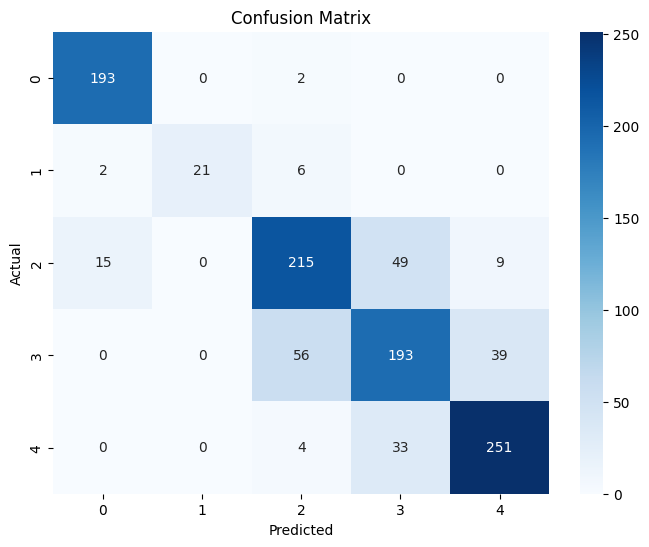

In [28]:
# confusion matrix 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
import pandas as pd

# Feature importance 수치와 feature 이름을 바탕으로 DataFrame 생성
feature_importances = model.get_feature_importance()
feature_names = X.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

fi_df.head(20)

,Feature,Importance
0,정상청구원금_B5M,9.311535
1,정상청구원금_B2M,5.494785
2,정상청구원금_B0M,3.575193
3,입회경과개월수_신용,3.271199
4,연체입금원금_B5M,2.584947
5,카드이용한도금액_B2M,2.518559
6,카드이용한도금액,2.480272
7,CA한도금액,2.318729
8,카드이용한도금액_B1M,2.001553
9,최대이용금액_일시불_R12M,1.736783


In [ ]:
# 누적 중요도 비율 계산
fi_df['Cumulative'] = fi_df['Importance'].cumsum() / fi_df['Importance'].sum()

# 상위 70% 중요도를 차지하는 컬럼만 선택
selected_features = fi_df[fi_df['Cumulative'] <= 0.7]['Feature'].tolist()

print(f"선택된 Feature 개수: {len(selected_features)}")

# X 데이터에서 해당 컬럼만 남기기
X_selected_70 = X[selected_features]

선택된 Feature 개수: 82


재훈련

In [46]:
from catboost import Pool, CatBoostClassifier

# 데이터 분할 (train/test)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected_70, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = X_selected_70.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)


model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    # eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 1.5320700	test: 1.5353357	best: 1.5353357 (0)	total: 42.5ms	remaining: 42.5s
100:	learn: 0.5574121	test: 0.6194798	best: 0.6194798 (100)	total: 4.32s	remaining: 38.4s
200:	learn: 0.4627381	test: 0.5620929	best: 0.5620929 (200)	total: 8.47s	remaining: 33.7s
300:	learn: 0.4053515	test: 0.5367325	best: 0.5367325 (300)	total: 12.6s	remaining: 29.2s
400:	learn: 0.3612142	test: 0.5210482	best: 0.5210482 (400)	total: 16.7s	remaining: 25s
500:	learn: 0.3288008	test: 0.5121847	best: 0.5121847 (500)	total: 20.8s	remaining: 20.7s
600:	learn: 0.3019622	test: 0.5070810	best: 0.5070810 (600)	total: 25s	remaining: 16.6s
700:	learn: 0.2786252	test: 0.5033420	best: 0.5033420 (700)	total: 29.2s	remaining: 12.5s
800:	learn: 0.2582589	test: 0.4996334	best: 0.4996334 (800)	total: 33.4s	remaining: 8.29s
900:	learn: 0.2405310	test: 0.4968798	best: 0.4968711 (899)	total: 37.7s	remaining: 4.14s
999:	learn: 0.2245467	test: 0.4953031	best: 0.4953031 (999)	total: 42s	remaining: 0us

bestTest = 0.4953031

In [47]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro: 클래스별 평균, 불균형에 유리)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# 상세 리포트
print("\n Classification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.7987
F1 Score (macro): 0.8223

 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       195
           1       1.00      0.79      0.88        29
           2       0.76      0.74      0.75       288
           3       0.69      0.66      0.68       288
           4       0.84      0.86      0.85       288

    accuracy                           0.80      1088
   macro avg       0.84      0.81      0.82      1088
weighted avg       0.80      0.80      0.80      1088



전체적으로 F1 score가 증가하였고, accuracy는 아주 미미하게 감소하였음.

### Catboost

하이퍼파라미터 튜닝 (using optuna)

In [ ]:
# 데이터 분할 (train/test)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected_70, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
# val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

In [56]:
from catboost import CatBoostClassifier
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
import random
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 300, 500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 15),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'task_type': 'GPU',
        'verbose': 0,
        'random_state': 42
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_features)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc

In [57]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("✅ Best Trial:")
print(study.best_trial.params)

[I 2025-03-29 18:28:27,193] A new study created in memory with name: no-name-a97ac356-be1d-4ccd-9829-d5f197babd83


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-03-29 18:28:46,633] Trial 0 finished with value: 0.7922794117647058 and parameters: {'iterations': 300, 'learning_rate': 0.1151215729157207, 'depth': 5, 'l2_leaf_reg': 5, 'border_count': 64, 'random_strength': 14}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:28:53,694] Trial 1 finished with value: 0.7270220588235294 and parameters: {'iterations': 100, 'learning_rate': 0.015222384210345722, 'depth': 6, 'l2_leaf_reg': 2, 'border_count': 64, 'random_strength': 5}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:29:05,243] Trial 2 finished with value: 0.7803308823529411 and parameters: {'iterations': 500, 'learning_rate': 0.0857171667033924, 'depth': 4, 'l2_leaf_reg': 15, 'border_count': 128, 'random_strength': 8}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:29:24,180] Trial 3 finished with value: 0.7729779411764706 and parameters: {'iterations': 300, 'learning_rate': 0.02138870077177371, 'depth': 10, 'l2_leaf_reg': 2, 'border_count': 32, 'random_strength': 7}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:29:50,582] Trial 4 finished with value: 0.7775735294117647 and parameters: {'iterations': 500, 'learning_rate': 0.03052522172005572, 'depth': 10, 'l2_leaf_reg': 3, 'border_count': 128, 'random_strength': 19}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:29:57,106] Trial 5 finished with value: 0.7610294117647058 and parameters: {'iterations': 200, 'learning_rate': 0.1175761703079716, 'depth': 3, 'l2_leaf_reg': 10, 'border_count': 64, 'random_strength': 20}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:30:06,721] Trial 6 finished with value: 0.7784926470588235 and parameters: {'iterations': 500, 'learning_rate': 0.09362160764327226, 'depth': 2, 'l2_leaf_reg': 1, 'border_count': 128, 'random_strength': 15}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:30:31,546] Trial 7 finished with value: 0.7913602941176471 and parameters: {'iterations': 500, 'learning_rate': 0.10233375518112517, 'depth': 9, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 2}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:30:53,852] Trial 8 finished with value: 0.7821691176470589 and parameters: {'iterations': 500, 'learning_rate': 0.04013022847878232, 'depth': 8, 'l2_leaf_reg': 8, 'border_count': 128, 'random_strength': 7}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:31:01,870] Trial 9 finished with value: 0.7536764705882353 and parameters: {'iterations': 300, 'learning_rate': 0.05795932956873807, 'depth': 2, 'l2_leaf_reg': 3, 'border_count': 128, 'random_strength': 8}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:31:12,354] Trial 10 finished with value: 0.7895220588235294 and parameters: {'iterations': 300, 'learning_rate': 0.17552086722953453, 'depth': 6, 'l2_leaf_reg': 11, 'border_count': 64, 'random_strength': 13}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:31:23,540] Trial 11 finished with value: 0.7876838235294118 and parameters: {'iterations': 200, 'learning_rate': 0.13290728840038032, 'depth': 8, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 2}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:31:30,158] Trial 12 finished with value: 0.7555147058823529 and parameters: {'iterations': 100, 'learning_rate': 0.15135792056136962, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 13}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:31:44,694] Trial 13 finished with value: 0.7858455882352942 and parameters: {'iterations': 300, 'learning_rate': 0.08254701886909226, 'depth': 8, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 1}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:32:01,698] Trial 14 finished with value: 0.7858455882352942 and parameters: {'iterations': 500, 'learning_rate': 0.18937015069783608, 'depth': 7, 'l2_leaf_reg': 5, 'border_count': 64, 'random_strength': 16}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:32:10,791] Trial 15 finished with value: 0.7775735294117647 and parameters: {'iterations': 300, 'learning_rate': 0.14459392612010122, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 32, 'random_strength': 11}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:32:20,209] Trial 16 finished with value: 0.7720588235294118 and parameters: {'iterations': 100, 'learning_rate': 0.1152383246388762, 'depth': 9, 'l2_leaf_reg': 10, 'border_count': 64, 'random_strength': 4}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:32:28,522] Trial 17 finished with value: 0.7702205882352942 and parameters: {'iterations': 200, 'learning_rate': 0.0677923629269793, 'depth': 6, 'l2_leaf_reg': 4, 'border_count': 32, 'random_strength': 10}. Best is trial 0 with value: 0.7922794117647058.


[I 2025-03-29 18:32:45,361] Trial 18 finished with value: 0.7931985294117647 and parameters: {'iterations': 500, 'learning_rate': 0.164870827657363, 'depth': 7, 'l2_leaf_reg': 14, 'border_count': 64, 'random_strength': 17}. Best is trial 18 with value: 0.7931985294117647.


[I 2025-03-29 18:32:54,617] Trial 19 finished with value: 0.78125 and parameters: {'iterations': 300, 'learning_rate': 0.19950701425917766, 'depth': 5, 'l2_leaf_reg': 15, 'border_count': 64, 'random_strength': 18}. Best is trial 18 with value: 0.7931985294117647.


[I 2025-03-29 18:33:15,740] Trial 20 finished with value: 0.7950367647058824 and parameters: {'iterations': 500, 'learning_rate': 0.1663606393561536, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 17}. Best is trial 20 with value: 0.7950367647058824.


[I 2025-03-29 18:33:32,706] Trial 21 finished with value: 0.7959558823529411 and parameters: {'iterations': 500, 'learning_rate': 0.16933406135573184, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 17}. Best is trial 21 with value: 0.7959558823529411.


[I 2025-03-29 18:33:49,537] Trial 22 finished with value: 0.7987132352941176 and parameters: {'iterations': 500, 'learning_rate': 0.16776709065673923, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 18}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:34:06,730] Trial 23 finished with value: 0.7904411764705882 and parameters: {'iterations': 500, 'learning_rate': 0.1711877011170606, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 20}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:34:23,948] Trial 24 finished with value: 0.7941176470588235 and parameters: {'iterations': 500, 'learning_rate': 0.15543307136363188, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 17}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:34:47,429] Trial 25 finished with value: 0.7904411764705882 and parameters: {'iterations': 500, 'learning_rate': 0.18474679324320997, 'depth': 9, 'l2_leaf_reg': 12, 'border_count': 64, 'random_strength': 18}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:35:02,725] Trial 26 finished with value: 0.7922794117647058 and parameters: {'iterations': 500, 'learning_rate': 0.13632416788451318, 'depth': 6, 'l2_leaf_reg': 12, 'border_count': 64, 'random_strength': 15}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:35:26,753] Trial 27 finished with value: 0.7977941176470589 and parameters: {'iterations': 500, 'learning_rate': 0.15906430355279524, 'depth': 8, 'l2_leaf_reg': 10, 'border_count': 64, 'random_strength': 11}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:35:46,582] Trial 28 finished with value: 0.7941176470588235 and parameters: {'iterations': 500, 'learning_rate': 0.1310732592152575, 'depth': 8, 'l2_leaf_reg': 10, 'border_count': 64, 'random_strength': 11}. Best is trial 22 with value: 0.7987132352941176.


[I 2025-03-29 18:36:00,689] Trial 29 finished with value: 0.7987132352941176 and parameters: {'iterations': 500, 'learning_rate': 0.1963468320122478, 'depth': 5, 'l2_leaf_reg': 9, 'border_count': 64, 'random_strength': 13}. Best is trial 22 with value: 0.7987132352941176.
✅ Best Trial:
{'iterations': 500, 'learning_rate': 0.16776709065673923, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 18}


최적 파라미터로 학습


In [59]:
# {'iterations': 500, 'learning_rate': 0.16776709065673923, 'depth': 7, 'l2_leaf_reg': 13, 'border_count': 64, 'random_strength': 18}
# 최적 파라미터로 최종 학습
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train, cat_features = cat_features)

0:	learn: 1.4822262	total: 27ms	remaining: 13.5s
1:	learn: 1.4298273	total: 32.2ms	remaining: 8.02s
2:	learn: 1.3415592	total: 60.8ms	remaining: 10.1s
3:	learn: 1.2819336	total: 69.3ms	remaining: 8.59s
4:	learn: 1.2289848	total: 74ms	remaining: 7.32s
5:	learn: 1.2066749	total: 89.9ms	remaining: 7.4s
6:	learn: 1.1693936	total: 114ms	remaining: 8.01s
7:	learn: 1.1623277	total: 125ms	remaining: 7.69s
8:	learn: 1.0963349	total: 153ms	remaining: 8.35s
9:	learn: 1.0803464	total: 170ms	remaining: 8.32s
10:	learn: 1.0602064	total: 182ms	remaining: 8.11s
11:	learn: 1.0309448	total: 201ms	remaining: 8.17s
12:	learn: 1.0251696	total: 208ms	remaining: 7.78s
13:	learn: 1.0212959	total: 217ms	remaining: 7.55s
14:	learn: 1.0021502	total: 255ms	remaining: 8.25s
15:	learn: 0.9958185	total: 283ms	remaining: 8.57s
16:	learn: 0.9823231	total: 320ms	remaining: 9.09s
17:	learn: 0.9779514	total: 324ms	remaining: 8.69s
18:	learn: 0.9664853	total: 344ms	remaining: 8.7s
19:	learn: 0.9465157	total: 370ms	remaini

In [61]:
# 검증 데이터로 성능 확인
y_pred = best_model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro: 클래스별 평균, 불균형에 유리)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# 상세 리포트
print("\n Classification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.7914
F1 Score (macro): 0.7863

 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       195
           1       0.86      0.62      0.72        29
           2       0.74      0.75      0.75       288
           3       0.70      0.65      0.67       288
           4       0.84      0.86      0.85       288

    accuracy                           0.79      1088
   macro avg       0.81      0.77      0.79      1088
weighted avg       0.79      0.79      0.79      1088



## 모델 사이즈 키워보기 1 (15배)

#### Preprocessing

함수 정의

In [3]:
# 샘플링 함수 (클래스 불균형 완화를 위함)
def stratified_resample_by_segment(df: pd.DataFrame, b_ratio=1, c_ratio=15, d_ratio=15, e_ratio=15):
    b_count = df[df['Segment'] == 'B'].shape[0]
    sampled_df = pd.concat([
        df[df['Segment'] == 'A'],
        df[df['Segment'] == 'C'].sample(n=b_count * c_ratio, random_state=42, replace=True),
        df[df['Segment'] == 'D'].sample(n=b_count * d_ratio, random_state=42, replace=True),
        df[df['Segment'] == 'E'].sample(n=b_count * e_ratio, random_state=42, replace=True),
        df[df['Segment'] == 'B']
    ])
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return sampled_df

# 사용법: 
# sampled_df = stratified_resample_by_segment(train_df)


# 통합 전처리 함수
from sklearn.feature_selection import VarianceThreshold

def full_preprocess_pipeline(df: pd.DataFrame, threshold: float = 0.02) -> pd.DataFrame:
    df = df.copy()

    # 0. test_df에 없는 컬럼 제거
    if test_df is not None:
        common_cols = [col for col in df.columns if col in test_df.columns or col == 'Segment']
        df = df[common_cols]

    # 1. 숫자형 변수 전처리
    numeric = df.select_dtypes(include=[np.number])
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(numeric)
    selected_columns = numeric.columns[selector.get_support()]
    X_selected_df = pd.DataFrame(X_selected, columns=selected_columns)

    # 2. 범주형 변수 병합
    X_categorical = df.select_dtypes(include=['object', 'category']).reset_index(drop=True)
    df_combined = pd.concat([X_selected_df.reset_index(drop=True), X_categorical], axis=1)

    # 3. 불필요한 컬럼 제거
    drop_keywords = ['일자', '방문', '청구서발송여부', '대표결제일', '년월']
    drop_exact = ['수신거부여부_TM', '기준년월', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', 'ID']
    cols_to_drop = [col for col in df_combined.columns if any(k in col for k in drop_keywords) or col in drop_exact]
    df_combined = df_combined.drop(columns=cols_to_drop, errors='ignore')

    # 4. 이상값 처리
    df_combined['rv최초시작후경과일'] = df_combined['rv최초시작후경과일'].replace(99999999.0, np.nan)
    df_combined['연체일수_B2M'] = df_combined['연체일수_B2M'].replace(-999999.0, np.nan)
    df_combined['연체일수_B1M'] = df_combined['연체일수_B1M'].replace(-999999.0, np.nan)
    df_combined['연체일수_최근'] = df_combined['연체일수_최근'].replace(-999999.0, np.nan)

    # 5. None → np.nan
    df_combined = df_combined.replace({None: np.nan})

    return df_combined

# 사용법
# processed_df = full_preprocess_pipeline(train_df)

def drop_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.95, show_corr: bool = True) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    if show_corr:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
        plt.title('Correlation Matrix (Before Dropping)')
        plt.tight_layout()
        plt.show()

    return df.drop(columns=to_drop, errors='ignore')

# 사용법
# processed_df = full_preprocess_pipeline(train_df, test_df=test_df, show_corr=True)
# df_cleaned = drop_highly_correlated_features(processed_df, threshold=0.95)

In [71]:
sampled_df = stratified_resample_by_segment(train_df)
df = full_preprocess_pipeline(sampled_df)
df.head()

,남녀구분코드,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지카드수_유효_신용,소지카드수_이용가능_신용,입회경과개월수_신용,이용거절여부_카드론,동의여부_한도증액안내,탈회횟수_누적,...,대표청구지고객주소구분코드,대표청구서수령지구분코드,청구서수령방법,할인건수_R3M,할인건수_B0M,인입횟수_ARS_R6M,이용메뉴건수_ARS_R6M,OS구분코드,캠페인접촉건수_R12M,캠페인접촉일수_R12M
0,1.0,1.0,1.0,1.0,1.0,1.0,288.0,0.0,0.0,0.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,NaN,1회 이상,1일 이상
1,2.0,1.0,1.0,0.0,1.0,1.0,5.0,0.0,0.0,1.0,...,주거지,우편,우편,10회 이상,1회 이상,1회 이상,1회 이상,NaN,10회 이상,10일 이상
2,2.0,1.0,1.0,1.0,1.0,1.0,58.0,0.0,0.0,0.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,NaN,1회 이상,1일 이상
3,1.0,1.0,1.0,1.0,2.0,2.0,26.0,0.0,0.0,0.0,...,미확인,이메일,이메일,1회 이상,1회 이상,1회 이상,1회 이상,Android,15회 이상,15일 이상
4,2.0,1.0,1.0,1.0,3.0,3.0,238.0,0.0,1.0,1.0,...,미확인,이메일,이메일,1회 이상,1회 이상,1회 이상,1회 이상,Android,10회 이상,10일 이상


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45376 (\N{HANGUL SYLLABLE NYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: User

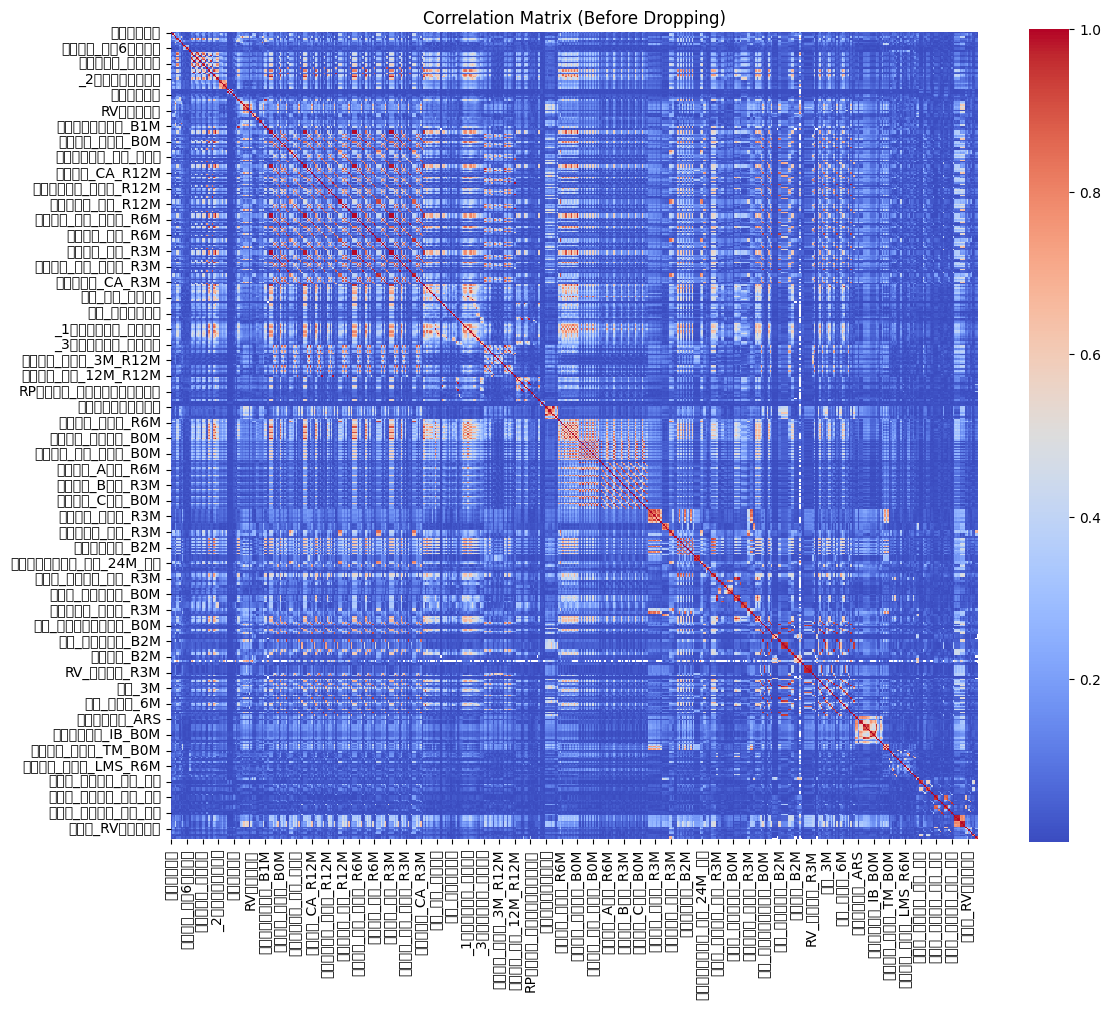

In [78]:
# 전처리 끝난 후 적용
df_cleaned = drop_highly_correlated_features(df, threshold=0.95)

In [80]:
df = df_cleaned.copy()

#### 훈련

In [81]:
# 1. X, y 나누기
feature_cols = [col for col in df.columns if col not in ["ID", "Segment"]]
X = df[feature_cols].copy()
y = df["Segment"].copy()

# y 인코딩
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# object & category 컬럼 → 문자열로 통일 (모델이 확실히 인식하도록)
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype(str)

# 명시적으로 category 타입으로 변환
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = X[col].astype('category')

# cat_features 리스트 만들기
cat_features = X.select_dtypes(include='category').columns.tolist()

print("✅ 카테고리 컬럼 목록:")
print(cat_features)

✅ 카테고리 컬럼 목록:
['연령', '가입통신회사코드', '거주시도명', '직장시도명', '_1순위신용체크구분', '_2순위신용체크구분', '연회비발생카드수_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', 'Life_Stage', '자발한도감액횟수_R12M', '한도증액횟수_R12M', '카드론동의여부', 'RV전환가능여부', '한도심사요청건수', '_1순위업종', '_2순위업종', '_3순위업종', '_1순위쇼핑업종', '_2순위쇼핑업종', '_3순위쇼핑업종', '_1순위교통업종', '_2순위교통업종', '_1순위납부업종', '이용금액대', '대표결제방법코드', '대표청구지고객주소구분코드', '대표청구서수령지구분코드', '청구서수령방법', '할인건수_R3M', '할인건수_B0M', '인입횟수_ARS_R6M', '이용메뉴건수_ARS_R6M', 'OS구분코드', '캠페인접촉건수_R12M', '캠페인접촉일수_R12M']


In [82]:
from catboost import Pool, CatBoostClassifier

# 데이터 분할 (train/test)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)


model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    # eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 1.5346848	test: 1.5349052	best: 1.5349052 (0)	total: 63.5ms	remaining: 1m 3s
100:	learn: 0.5886377	test: 0.6289073	best: 0.6289073 (100)	total: 8.47s	remaining: 1m 15s
200:	learn: 0.5035918	test: 0.5782475	best: 0.5782475 (200)	total: 17s	remaining: 1m 7s
300:	learn: 0.4472859	test: 0.5524086	best: 0.5523618 (299)	total: 25.4s	remaining: 59s
400:	learn: 0.4076024	test: 0.5377981	best: 0.5377981 (400)	total: 33.8s	remaining: 50.5s
500:	learn: 0.3780804	test: 0.5277364	best: 0.5277364 (500)	total: 42.4s	remaining: 42.2s
600:	learn: 0.3538131	test: 0.5216031	best: 0.5216031 (600)	total: 51s	remaining: 33.8s
700:	learn: 0.3315403	test: 0.5147363	best: 0.5147363 (700)	total: 59.5s	remaining: 25.4s
800:	learn: 0.3128282	test: 0.5099829	best: 0.5099829 (800)	total: 1m 7s	remaining: 16.9s
900:	learn: 0.2961510	test: 0.5060477	best: 0.5060477 (900)	total: 1m 16s	remaining: 8.39s
999:	learn: 0.2821353	test: 0.5027850	best: 0.5027850 (999)	total: 1m 25s	remaining: 0us

bestTest = 0.5027

In [83]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro: 클래스별 평균, 불균형에 유리)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# 상세 리포트
print("\n Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.8026
F1 Score (macro): 0.8130

 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       195
           1       0.95      0.66      0.78        29
           2       0.78      0.75      0.77       432
           3       0.71      0.71      0.71       432
           4       0.86      0.87      0.87       432

    accuracy                           0.80      1520
   macro avg       0.84      0.80      0.81      1520
weighted avg       0.80      0.80      0.80      1520



#### Feature importance 기반 재훈련 (80%)

요약: 정확도는 조금 떨어졌으나 (0.0x 선), F1 score 증가.

In [ ]:
import pandas as pd

# Feature importance 수치와 feature 이름을 바탕으로 DataFrame 생성
feature_importances = model.get_feature_importance()
feature_names = X.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

fi_df.head(5)

# 누적 중요도 비율 계산
fi_df['Cumulative'] = fi_df['Importance'].cumsum() / fi_df['Importance'].sum()

# 상위 70% 중요도를 차지하는 컬럼만 선택
selected_features = fi_df[fi_df['Cumulative'] <= 0.8]['Feature'].tolist()

print(f"선택된 Feature 개수: {len(selected_features)}")

# X 데이터에서 해당 컬럼만 남기기
X_selected_80 = X[selected_features]

,Feature,Importance
0,정상청구원금_B5M,9.225501
1,카드이용한도금액,5.016039
2,정상청구원금_B0M,4.585791
3,정상청구원금_B2M,4.276081
4,입회경과개월수_신용,4.232556


In [90]:
from catboost import Pool, CatBoostClassifier

# 데이터 분할 (train/test)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected_80, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = X_selected_80.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)


model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    # eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 1.5295361	test: 1.5323097	best: 1.5323097 (0)	total: 33ms	remaining: 32.9s
100:	learn: 0.5791532	test: 0.6204006	best: 0.6204006 (100)	total: 4.82s	remaining: 42.9s
200:	learn: 0.4924468	test: 0.5713483	best: 0.5713483 (200)	total: 9.66s	remaining: 38.4s
300:	learn: 0.4302946	test: 0.5462285	best: 0.5461866 (299)	total: 14.4s	remaining: 33.5s
400:	learn: 0.3887469	test: 0.5339921	best: 0.5339921 (400)	total: 19.3s	remaining: 28.9s
500:	learn: 0.3572531	test: 0.5265949	best: 0.5264171 (494)	total: 24.2s	remaining: 24.1s
600:	learn: 0.3318263	test: 0.5196818	best: 0.5196372 (599)	total: 29.3s	remaining: 19.4s
700:	learn: 0.3088445	test: 0.5150799	best: 0.5150649 (699)	total: 34.2s	remaining: 14.6s
800:	learn: 0.2887384	test: 0.5114194	best: 0.5114194 (800)	total: 39.2s	remaining: 9.73s
900:	learn: 0.2689848	test: 0.5074019	best: 0.5073787 (899)	total: 44s	remaining: 4.83s
999:	learn: 0.2508139	test: 0.5039370	best: 0.5039118 (998)	total: 48.8s	remaining: 0us

bestTest = 0.50391

In [91]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro: 클래스별 평균, 불균형에 유리)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# 상세 리포트
print("\n Classification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.7928
F1 Score (macro): 0.8194

 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       195
           1       0.96      0.76      0.85        29
           2       0.77      0.74      0.75       432
           3       0.68      0.71      0.70       432
           4       0.86      0.85      0.85       432

    accuracy                           0.79      1520
   macro avg       0.84      0.81      0.82      1520
weighted avg       0.79      0.79      0.79      1520



#### 추가 방법론

**추가로 수행해볼 것:**

- 데이터셋 10000개까지 늘리기 (가중치 조정이 필요할 듯?)
- 추가로 정리할만한 컬럼 들여다보기
- tabnet이나 resnet, or tabM 구현해보기


## 모델 사이즈 키워보기 2 (20배)

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45376 (\N{HANGUL SYLLABLE NYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/

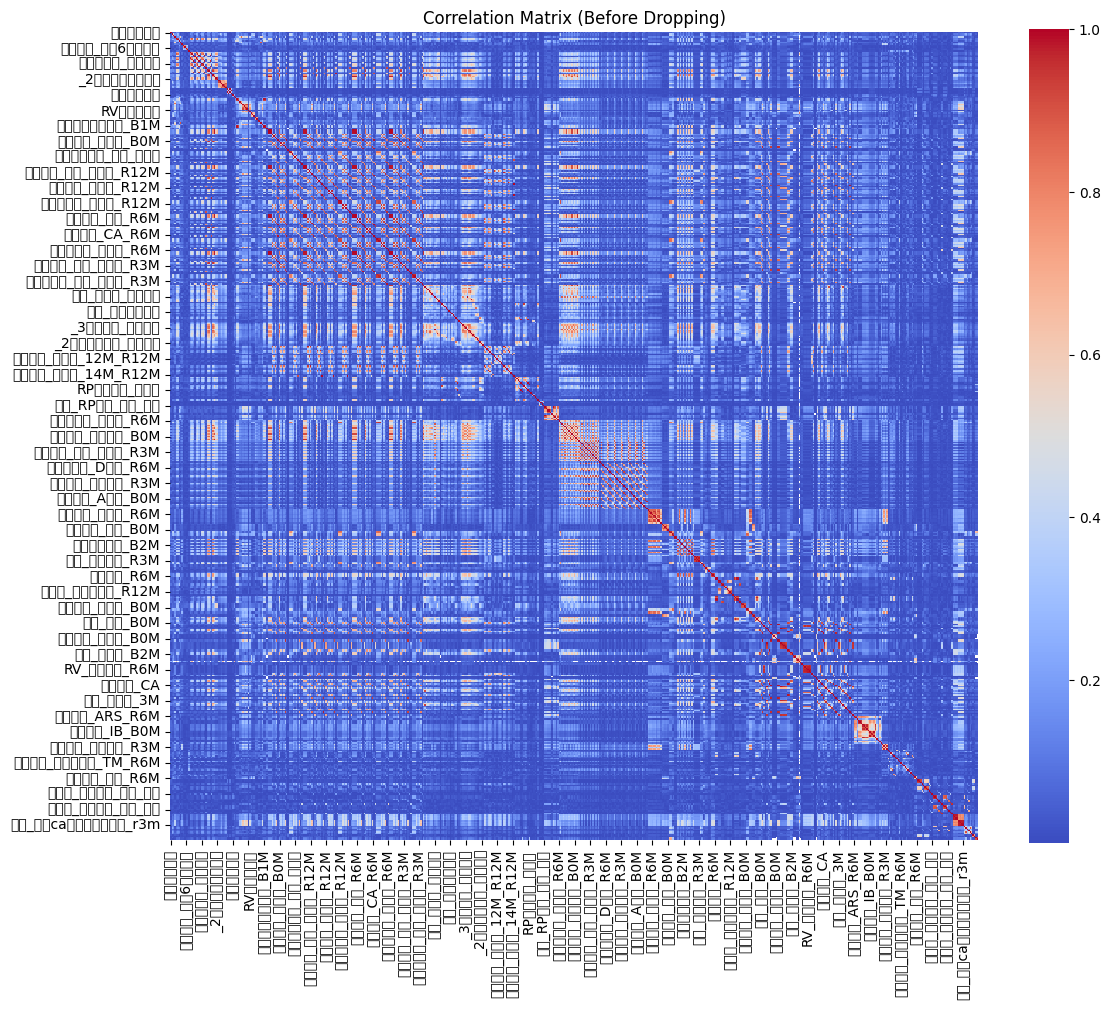

,남녀구분코드,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지카드수_유효_신용,소지카드수_이용가능_신용,입회경과개월수_신용,이용거절여부_카드론,동의여부_한도증액안내,탈회횟수_누적,...,대표청구지고객주소구분코드,대표청구서수령지구분코드,청구서수령방법,할인건수_R3M,할인건수_B0M,인입횟수_ARS_R6M,이용메뉴건수_ARS_R6M,OS구분코드,캠페인접촉건수_R12M,캠페인접촉일수_R12M
0,1.0,1.0,1.0,1.0,3.0,3.0,113.0,0.0,0.0,0.0,...,미확인,이메일,이메일,1회 이상,1회 이상,1회 이상,1회 이상,IOS,1회 이상,1일 이상
1,1.0,1.0,1.0,1.0,1.0,1.0,79.0,0.0,0.0,1.0,...,미확인,이메일,이메일,1회 이상,1회 이상,10회 이상,10회 이상,NaN,10회 이상,10일 이상
2,1.0,1.0,1.0,0.0,1.0,1.0,74.0,0.0,0.0,0.0,...,주거지,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,NaN,1회 이상,1일 이상
3,1.0,1.0,1.0,1.0,3.0,3.0,287.0,0.0,0.0,1.0,...,회사,우편,우편,1회 이상,1회 이상,1회 이상,1회 이상,IOS,1회 이상,1일 이상
4,1.0,1.0,0.0,1.0,3.0,3.0,175.0,0.0,0.0,0.0,...,미확인,당사페이앱+이메일,문자메세지,10회 이상,1회 이상,1회 이상,1회 이상,Android,1회 이상,1일 이상


In [4]:
sampled_df = stratified_resample_by_segment(train_df, b_ratio=1, c_ratio=20, d_ratio=20, e_ratio=20)
df = full_preprocess_pipeline(sampled_df)
df_cleaned = drop_highly_correlated_features(df, threshold=0.95)
df = df_cleaned.copy()
df.head(5)

### TabM 구현

In [32]:
# tabM 구조의 기본 뼈대 구현
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from tqdm import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # CUDA 디버깅 활성화

# 범주형, 수치형 컬럼 자동 분리 함수
def get_cat_num_columns(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return cat_cols, num_cols

class TabMDataset(Dataset):
    def __init__(self, df: pd.DataFrame, cat_cols, num_cols, target_col=None, cat_maps=None, mask_prob=0.15):
        self.df = df.reset_index(drop=True)
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col
        self.mask_prob = mask_prob

        if cat_maps is None:
            self.cat_maps = {
                col: {v: i+1 for i, v in enumerate(self.df[col].astype('category').cat.categories)}
                for col in self.cat_cols
            }
        else:
            self.cat_maps = cat_maps

        for col in self.cat_cols:
            if len(self.cat_maps[col]) == 0:
                print(f"⚠️ {col} has no categories! Using default 0.")
                self.cat_maps[col] = {'__MISSING__': 1}

        self.cat_data = np.stack([
            self.df[col].map(self.cat_maps[col]).fillna(0).astype(int).values for col in self.cat_cols
        ], axis=1)

        self.num_data = self.df[self.num_cols].fillna(0).values.astype(np.float32)
        self.targets = self.df[target_col].astype('category').cat.codes.values.astype(np.int64) if target_col else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_cat = torch.tensor(self.cat_data[idx], dtype=torch.long)
        x_num = torch.tensor(self.num_data[idx], dtype=torch.float32)
        mask = torch.rand(x_cat.shape[0]) < self.mask_prob
        x_cat_masked = x_cat.clone()
        x_cat_masked[mask] = 0

        return {
            'cat': x_cat_masked,
            'num': x_num,
            'cat_target': x_cat,
            'target': torch.tensor(self.targets[idx], dtype=torch.long) if self.target_col else None
        }

class TabMModel(nn.Module):
    def __init__(self, num_categories, num_numerical, emb_dim=32, n_heads=4, n_layers=2, n_classes=5):
        super().__init__()
        num_categories = [max(2, n) for n in num_categories]  # 최소 2 보장
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat, emb_dim) for n_cat in num_categories
        ])
        self.num_linear = nn.Linear(num_numerical, emb_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, len(num_categories) + 1, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.cat_decoder = nn.ModuleList([
            nn.Linear(emb_dim, n_cat) for n_cat in num_categories
        ])
        self.cls_head = nn.Linear(emb_dim, n_classes)

    def forward(self, x_cat, x_num):
        B = x_cat.size(0)
        cat_emb = torch.stack([emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)], dim=1)
        num_emb = self.num_linear(x_num).unsqueeze(1)

        x = torch.cat([self.cls_token.expand(B, -1, -1), cat_emb], dim=1)
        x = x + self.pos_embedding[:, :x.size(1)]
        x = self.transformer(x)

        cls_out = self.cls_head(x[:, 0])
        cat_outs = [decoder(x[:, i+1]) for i, decoder in enumerate(self.cat_decoder)]
        return cls_out, cat_outs

def predict_tabm(model, test_df, cat_cols, num_cols, cat_maps, num_categories, device):
    model.eval()

    # 누락된 수치형 컬럼 보완
    for col in num_cols:
        if col not in test_df.columns:
            test_df[col] = 0
    test_df = test_df[num_cols + cat_cols]  # 순서 강제 정렬

    cat_data = []
    for i, col in enumerate(cat_cols):
        mapped = test_df[col].map(cat_maps[col]).fillna(0).astype(int)
        mapped[mapped >= num_categories[i]] = 0
        cat_data.append(mapped.values)

    X_cat = torch.tensor(np.stack(cat_data, axis=1), dtype=torch.long).to(device)
    X_num = torch.tensor(test_df[num_cols].fillna(0).values, dtype=torch.float32).to(device)

    with torch.no_grad():
        cls_out, _ = model(X_cat, X_num)
        preds = cls_out.argmax(dim=1).cpu().numpy()
    return preds

In [33]:
# ===============================
# ✅ 실행 예시 코드
# ===============================
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
df['Segment'] = le_target.fit_transform(df['Segment'])

cat_cols, num_cols = get_cat_num_columns(df)
target_col = 'Segment'

# 전체 데이터 학습용으로 사용
train_ds = TabMDataset(df, cat_cols, num_cols, target_col)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
num_categories = [df[col].nunique() + 1 for col in cat_cols]
n_classes = df[target_col].dropna().nunique()

for i, col in enumerate(cat_cols):
    max_id = train_ds.cat_data[:, i].max()
    emb_size = num_categories[i]
    if max_id >= emb_size:
        print(f"❗ {col} has ID {max_id} but embedding size is {emb_size}")

In [34]:
# Jupyter에서 직접 셀 실행
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

tabm_model = TabMModel(num_categories, len(num_cols), n_classes=len(np.unique(df[target_col]))).to(device)

optimizer = torch.optim.Adam(tabm_model.parameters(), lr=1e-3)
criterion_cls = nn.CrossEntropyLoss()
criterion_cat = nn.CrossEntropyLoss()

In [58]:
# 학습 루프
for epoch in range(20):
    loss = train(tabm_model, train_loader, optimizer, criterion_cls, criterion_cat, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Training: 100%|██████████| 153/153 [00:08<00:00, 18.75it/s]


Epoch 1, Loss: 1.2770


Training: 100%|██████████| 153/153 [00:08<00:00, 17.60it/s]


Epoch 2, Loss: 1.2215


Training: 100%|██████████| 153/153 [00:09<00:00, 16.35it/s]


Epoch 3, Loss: 1.1944


Training: 100%|██████████| 153/153 [00:09<00:00, 15.94it/s]


Epoch 4, Loss: 1.1739


Training: 100%|██████████| 153/153 [00:09<00:00, 15.92it/s]


Epoch 5, Loss: 1.1584


Training: 100%|██████████| 153/153 [00:09<00:00, 16.05it/s]


Epoch 6, Loss: 1.1352


Training: 100%|██████████| 153/153 [00:09<00:00, 16.01it/s]


Epoch 7, Loss: 1.1326


Training: 100%|██████████| 153/153 [00:09<00:00, 15.79it/s]


Epoch 8, Loss: 1.1194


Training: 100%|██████████| 153/153 [00:09<00:00, 15.59it/s]


Epoch 9, Loss: 1.1160


Training: 100%|██████████| 153/153 [00:09<00:00, 15.83it/s]


Epoch 10, Loss: 1.1070


Training: 100%|██████████| 153/153 [00:09<00:00, 15.76it/s]


Epoch 11, Loss: 1.1062


Training: 100%|██████████| 153/153 [00:09<00:00, 15.63it/s]


Epoch 12, Loss: 1.0991


Training: 100%|██████████| 153/153 [00:09<00:00, 16.09it/s]


Epoch 13, Loss: 1.1005


Training: 100%|██████████| 153/153 [00:09<00:00, 16.03it/s]


Epoch 14, Loss: 1.0878


Training: 100%|██████████| 153/153 [00:09<00:00, 16.03it/s]


Epoch 15, Loss: 1.0855


Training: 100%|██████████| 153/153 [00:09<00:00, 16.04it/s]


Epoch 16, Loss: 1.0810


Training: 100%|██████████| 153/153 [00:09<00:00, 15.33it/s]


Epoch 17, Loss: 1.0803


Training: 100%|██████████| 153/153 [00:10<00:00, 14.90it/s]


Epoch 18, Loss: 1.0723


Training: 100%|██████████| 153/153 [00:10<00:00, 15.06it/s]


Epoch 19, Loss: 1.0720


Training: 100%|██████████| 153/153 [00:10<00:00, 15.24it/s]

Epoch 20, Loss: 1.0666


In [59]:
# 모델 저장
torch.save(tabm_model, "tabm_model_full.pth")

## 불러오는 법법
# tabm_model = torch.load("tabm_model_full.pth")
# tabm_model.eval()


### Prediction :: Test dataset

In [36]:
# # X에서 dtype이 object인 열만 선택, 즉 범주형 변수들만 선택해서 리스트로 저장
# categorical_features = test_df.select_dtypes(include=['object']).columns.tolist()

# X_test = test_df.copy()

# encoders = {}  # 각 컬럼별 encoder 저장

# for col in categorical_features:
#     le_train = LabelEncoder()
#     X_test[col] = le_train.fit_transform(X_test[col])
#     encoders[col] = le_train
#     unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
#     # test 데이터에는 train에서 보지 못한 새로운 label이 있을 수 있음
#     # 예: train에는 "A", "B"만 있었는데 test에 "C"가 등장한 경우
#     if unseen_labels_val:
#         le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
#     X_test[col] = le_train.transform(X_test[col])

# gc.collect()
# # 불필요한 메모리 사용량을 줄이기 위해 Garbage Collector 실행

3473

In [60]:
def predict_tabm_batch(model, test_df, cat_cols, num_cols, cat_maps, num_categories, device, batch_size=1024):
    model.eval()

    # 누락된 수치형 컬럼 보완
    for col in num_cols:
        if col not in test_df.columns:
            test_df[col] = 0
    for col in cat_cols:
        if col not in test_df.columns:
            test_df[col] = "__MISSING__"
    
    test_df = test_df[num_cols + cat_cols]  # 순서 고정

    preds = []
    num_samples = len(test_df)

    for i in range(0, num_samples, batch_size):
        batch_df = test_df.iloc[i:i+batch_size]

        # 범주형 매핑
        cat_data = []
        for j, col in enumerate(cat_cols):
            mapped = batch_df[col].map(cat_maps[col]).fillna(0).astype(int)
            mapped[mapped >= num_categories[j]] = 0
            cat_data.append(mapped.values)

        X_cat = torch.tensor(np.stack(cat_data, axis=1), dtype=torch.long).to(device)
        X_num = torch.tensor(batch_df[num_cols].fillna(0).values, dtype=torch.float32).to(device)

        with torch.no_grad():
            cls_out, _ = model(X_cat, X_num)
            pred = cls_out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)

    return np.array(preds)

In [61]:
y_test_pred = predict_tabm_batch(
    tabm_model, test_df,
    cat_cols, num_cols,
    train_ds.cat_maps, num_categories,
    device=device,
    batch_size=3000  # 여유 있으면 더 키워도 OK
)

In [62]:
test_data = test_df.copy()  # 원본 유지
test_data["pred_label"] = y_test_pred

label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

test_data['pred_label'] = test_data['pred_label'].map(label_map)

In [63]:
test_data

,기준년월,ID,남녀구분코드,연령,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,...,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M,Segment,pred_label
0,201807,TEST_00000,1,40대,1,1,0,1,2,2,...,0.999998,0.999998,0.999998,0.209395,0.231043,0.0,1.332770,1.780392,0,D
1,201807,TEST_00001,1,60대,1,1,0,1,1,1,...,1.991974,0.999998,0.926569,-0.269161,-0.247241,0.0,0.000000,0.000000,0,D
2,201807,TEST_00002,1,40대,1,1,1,1,2,2,...,0.999998,0.999998,0.999998,-0.120290,0.029270,0.0,4.123738,5.115589,0,C
3,201807,TEST_00003,2,40대,1,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.035807,-0.013359,0.0,0.093615,0.349994,0,E
4,201807,TEST_00004,2,40대,1,0,1,1,1,1,...,0.999998,0.999998,0.999998,-0.538740,-0.449378,0.0,0.000000,0.000000,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,201812,TEST_99995,2,60대,0,0,0,0,0,0,...,0.999998,0.999998,0.999998,0.000000,0.000000,0.0,NaN,NaN,0,E
599996,201812,TEST_99996,1,30대,1,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.143554,0.233616,0.0,8.564683,11.379632,0,E
599997,201812,TEST_99997,2,30대,1,1,1,1,1,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,0,E
599998,201812,TEST_99998,1,30대,1,1,1,1,3,3,...,0.999998,0.999998,0.999998,-0.038153,-0.106142,0.0,-0.241530,0.499079,0,C


### Submission

In [64]:
submission = test_data.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]

submission.to_csv('./base_submit.csv',index=False)